In [865]:
import csv
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import scipy
import sklearn
import shutil
import tensorflow as tf

from pandas import DataFrame
from pandas.tools.plotting import scatter_matrix
#from scipy.spatial.distance import mahalanobis # Not vectorized and terribly slow!
from sklearn import mixture
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import silhouette_samples
from tensorflow.examples.tutorials.mnist import input_data

pj = os.path.join

%matplotlib inline

In [866]:
if os.name == "nt":
    LOG_DIR = "tf_graphs/image"
    TRAIN_DIR = "J:/MLDataSets/MNIST"
else:
    raise RuntimeError("Don't have linux paths atm")

file_ct = 0

In [969]:
g_image_size = 28
g_color_list = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'r', 'g', 'b']

In [868]:
mnist = input_data.read_data_sets(TRAIN_DIR)

Extracting J:/MLDataSets/MNIST\train-images-idx3-ubyte.gz
Extracting J:/MLDataSets/MNIST\train-labels-idx1-ubyte.gz
Extracting J:/MLDataSets/MNIST\t10k-images-idx3-ubyte.gz
Extracting J:/MLDataSets/MNIST\t10k-labels-idx1-ubyte.gz


In [869]:
mnist.train.num_examples//g_batch_size

214

In [933]:
conf = {}
conf["batch_size"] = 256
conf["fc_bottleneck"] = True
conf["use_tutorial"] = False

conf["regularize"] = False
conf["num_epochs"] = 1500
conf["lambda"] = 0.1
conf["lr"] = 0.001
conf["momentum"] = 0.9

In [952]:
conf["numh"] = 8
conf["num_filts1"] = 32
conf["num_filts2"] = 16
conf["num_filts3"] = 8
conf["stride"] = 2
conf["pool_size"] = 2

#The size of the filters, *not* the size of the convolution kernel
conf["filt_size1"] = 3
conf["filt_size2"] = 3
conf["filt_size3"] = 3

conf["upsamp_sz1"] = 7
conf["upsamp_sz2"] = 14
conf["upsamp_sz3"] = 28

print("Number of samples: " + str(g_image_size))
print("Filt size 1: " + str(conf["filt_size1"]))
print("Filt size 2: " + str(conf["filt_size2"]))
print("Filt size 3: " + str(conf["filt_size3"]))


Number of samples: 28
Filt size 1: 3
Filt size 2: 3
Filt size 3: 3


In [953]:
tf.reset_default_graph()

In [954]:
x = tf.placeholder(tf.float32, shape=(None, g_image_size, g_image_size, 1), name="x")

In [957]:
def make_conv_layer(t_in, filt_sz, stride, pool_sz, num_filts, name):
    assert(len(t_in.shape)==4)
    with tf.name_scope(name):
        print("t_in: ", t_in.shape)
        filt_shape = [filt_sz, filt_sz, int(t_in.shape[3]), num_filts]
#        W = tf.Variable(tf.random_normal(filt_shape, stddev=0.1), name=name+"_W")
        W = tf.get_variable(name+"_W", filt_shape, initializer=tf.contrib.layers.xavier_initializer())
        print("W_conv: ", W.shape)
        #tf.layers.conv2d uses the glorot_uniform_initializer
        
#        b = tf.Variable(tf.random_normal([num_filts], stddev=0.1), name=name+"_b")
        b = tf.get_variable(name+"_b", [num_filts], initializer=tf.zeros_initializer())
        print("b_conv: ", b.shape)
        y = tf.nn.conv2d(t_in,
                         W,
                         [1, 1, 1, 1],
                         padding="SAME") + b
        print("y: ", y.shape)
        mp = tf.layers.max_pooling2d(y,
                                    pool_sz,
                                    strides=stride,
                                    padding="SAME",
                                    name=name+"_mp")
        act = tf.nn.relu(mp, name=name+"_relu")
        print("act: ", act.shape)
        return act   

In [958]:
def make_deconv_layer(t_in, upsamp_sz, num_filts, name, use_relu=True):
    assert(len(t_in.shape)==4)
    with tf.name_scope(name):
        upsample = tf.image.resize_nearest_neighbor(t_in, (upsamp_sz, upsamp_sz))
        print("upsample: ", upsample.shape)
        
        filt_shape = [int(t_in.shape[1]), int(t_in.shape[2]), int(t_in.shape[3]), num_filts]
#        W = tf.Variable(tf.random_normal(filt_shape, stddev=0.1), name=name+"_W")
        W = tf.get_variable(name+"_W", filt_shape, initializer=tf.contrib.layers.xavier_initializer())
        print("W_deconv: ", W.shape)
        
#        b = tf.Variable(tf.random_normal([num_filts], stddev=0.1), name=name+"_b")
        b = tf.get_variable(name+"_b", [num_filts], initializer=tf.zeros_initializer())
        print("b_deconv: ", b.shape)
    
        deconv = tf.nn.conv2d(upsample, 
                              W, 
                              [1, 1, 1, 1],
                              "SAME") + b
        print("deconv: ", deconv.shape)

        if use_relu:
            act = tf.nn.relu(deconv, name=name+"_relu")
        else:
            act = deconv
        print(act.shape)
        return act

In [959]:
def make_fc_layer(t_in, fan_out, name):
    assert(len(t_in.shape)==2)
    with tf.name_scope(name):
        W = tf.Variable(tf.random_normal([int(t_in.shape[1]), fan_out], stddev=1), name=name+"_W")
        b = tf.Variable(tf.random_normal([fan_out], stddev=1), name=name+"_b")
        y = tf.matmul(t_in, W) + b
        act = tf.nn.sigmoid(y, name=name+"_sigmoid")
        return act

In [960]:
conv1 = make_conv_layer(x, conf["filt_size1"], conf["stride"], conf["pool_size"], conf["num_filts1"], "conv1")
conv2 = make_conv_layer(conv1, conf["filt_size2"], conf["stride"], conf["pool_size"], conf["num_filts2"], "conv2")
conv3 = make_conv_layer(conv2, conf["filt_size3"], conf["stride"], conf["pool_size"], conf["num_filts3"], "conv3")

t_in:  (?, 28, 28, 1)
W_conv:  (3, 3, 1, 32)
b_conv:  (32,)
y:  (?, 28, 28, 32)
act:  (?, 14, 14, 32)
t_in:  (?, 14, 14, 32)
W_conv:  (3, 3, 32, 16)
b_conv:  (16,)
y:  (?, 14, 14, 16)
act:  (?, 7, 7, 16)
t_in:  (?, 7, 7, 16)
W_conv:  (3, 3, 16, 8)
b_conv:  (8,)
y:  (?, 7, 7, 8)
act:  (?, 4, 4, 8)


In [961]:
if conf["fc_bottleneck"]:
    fc_start0 = make_conv_layer(conv3, 2, 2, 2, conf["num_filts3"], "fc_start0")
    fc_start = tf.squeeze( make_conv_layer(fc_start0, 2, 2, 2, conf["num_filts3"], "conv_bottle"), [1, 2])

    hc = make_fc_layer(fc_start, conf["numh"], "hc")
    deconv_start0 = make_deconv_layer(tf.reshape(hc,[-1, 1, 1, int(hc.shape[1])]), 2, conf["num_filts3"], "deconv_start0")
    deconv_start = make_deconv_layer(deconv_start0, 2, conf["num_filts3"], "deconv_bottle")
else:
    deconv_start = conv3

t_in:  (?, 4, 4, 8)
W_conv:  (2, 2, 8, 8)
b_conv:  (8,)
y:  (?, 4, 4, 8)
act:  (?, 2, 2, 8)
t_in:  (?, 2, 2, 8)
W_conv:  (2, 2, 8, 8)
b_conv:  (8,)
y:  (?, 2, 2, 8)
act:  (?, 1, 1, 8)
upsample:  (?, 2, 2, 8)
W_deconv:  (1, 1, 8, 8)
b_deconv:  (8,)
deconv:  (?, 2, 2, 8)
(?, 2, 2, 8)
upsample:  (?, 2, 2, 8)
W_deconv:  (2, 2, 8, 8)
b_deconv:  (8,)
deconv:  (?, 2, 2, 8)
(?, 2, 2, 8)


In [962]:
deconv1 = make_deconv_layer(deconv_start, conf["upsamp_sz1"], conf["num_filts3"], "deconv1")
deconv2 = make_deconv_layer(deconv1, conf["upsamp_sz2"], conf["num_filts2"], "deconv2")
deconv3 = make_deconv_layer(deconv2, conf["upsamp_sz3"], conf["num_filts1"], "deconv3")

upsample:  (?, 7, 7, 8)
W_deconv:  (2, 2, 8, 8)
b_deconv:  (8,)
deconv:  (?, 7, 7, 8)
(?, 7, 7, 8)
upsample:  (?, 14, 14, 8)
W_deconv:  (7, 7, 8, 16)
b_deconv:  (16,)
deconv:  (?, 14, 14, 16)
(?, 14, 14, 16)
upsample:  (?, 28, 28, 16)
W_deconv:  (14, 14, 16, 32)
b_deconv:  (32,)
deconv:  (?, 28, 28, 32)
(?, 28, 28, 32)


In [963]:
out = tf.layers.conv2d(deconv3, 
                       1, 
                       (conf["filt_size1"], conf["filt_size1"]),
                       padding='same',
                       activation=None)
print("out: ", out.shape)

out:  (?, 28, 28, 1)


In [964]:
decoded = tf.nn.sigmoid(out, name='decoded')

In [965]:
with tf.name_scope("conv_mse"):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=out)
    cost = tf.reduce_mean(loss)
#    sq_error = tf.reduce_mean(np.square(out - x), axis=1)
#    cost = tf.reduce_mean( sq_error, name="cost" )
    
with tf.name_scope("conv_opt"):
    optimizer = tf.train.AdamOptimizer(learning_rate=conf["lr"])
#    optimizer = tf.train.RMSPropOptimizer(learning_rate=conf["lr"])
#    optimizer = tf.train.MomentumOptimizer(learning_rate=conf["lr"], momentum=conf["momentum"])
#    optimizer = tf.train.GradientDescentOptimizer(learning_rate=conf["lr"])
    training_op = optimizer.minimize(cost)

In [967]:
conf["num_epochs"] = 50

with tf.device("/gpu:0"):
    config = tf.ConfigProto(allow_soft_placement = True)
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())

    tf.summary.scalar("cost", cost)
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)

    for i in range(conf["num_epochs"]):
        for ii in range(mnist.train.num_examples//conf["batch_size"]):
            batch = mnist.train.next_batch(conf["batch_size"])
            imgs = batch[0].reshape((-1, g_image_size, g_image_size, 1))
            summary,_ = sess.run([merged, training_op], feed_dict={x : imgs})
            train_writer.add_summary(summary, i)
            if ii%100 == 0:
                print(cost.eval(session=sess, feed_dict={x : imgs}))

0.641831
0.259505
0.237748
0.221183
0.218125
0.209432
0.20141
0.189804
0.192862
0.193952
0.185882
0.185596
0.180879
0.180535
0.181551
0.181808
0.179854
0.178762
0.170304
0.178529
0.168308
0.176181
0.168972
0.161987
0.171063
0.172574
0.16783
0.168504
0.169634
0.171053
0.17239
0.165544
0.166578
0.164535
0.172222
0.165323
0.16146
0.160577
0.161007
0.161103
0.160952
0.167528
0.163258
0.159517
0.164434
0.161249
0.160078
0.161028
0.157643
0.155704
0.161704
0.169277
0.1608
0.151956
0.156108
0.160396
0.154617
0.162144
0.154451
0.154269
0.152085
0.150124
0.155536
0.152024
0.147669
0.157443
0.157974
0.15063
0.148879
0.155348
0.153822
0.153659
0.155085
0.146075
0.151592
0.150917
0.159262
0.148428
0.145933
0.154665
0.151109
0.147242
0.151731
0.147702
0.149896
0.152879
0.152285
0.150933
0.150145
0.142655
0.15484
0.136573
0.147479
0.145618
0.150532
0.146009
0.153205
0.14168
0.144453
0.137667
0.144715
0.140464
0.1407
0.152955
0.147408
0.142482
0.147286
0.144036
0.141329
0.138396
0.149704
0.144665
0.1

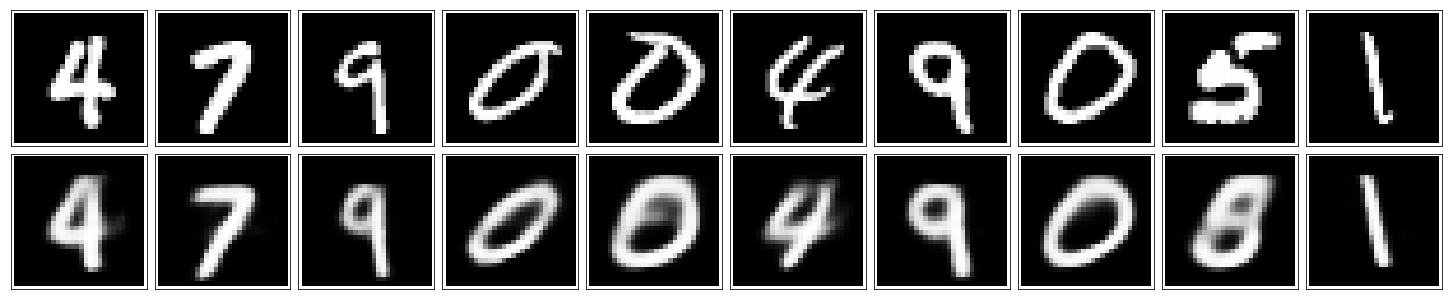

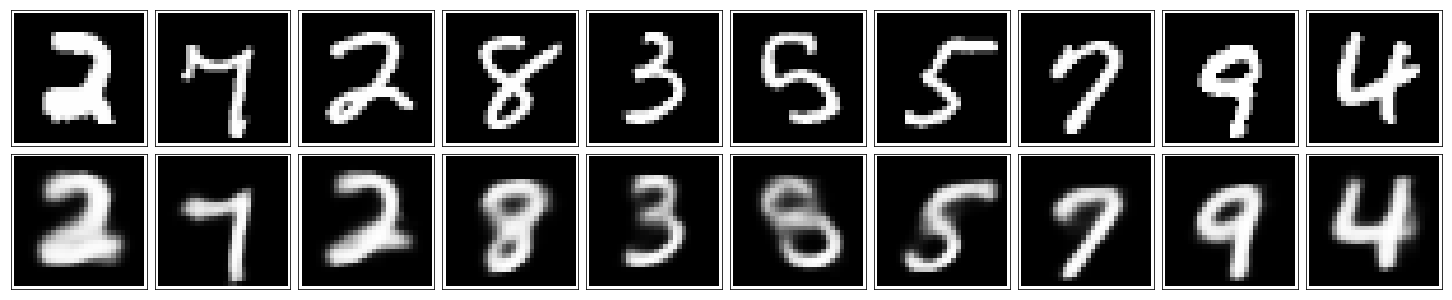

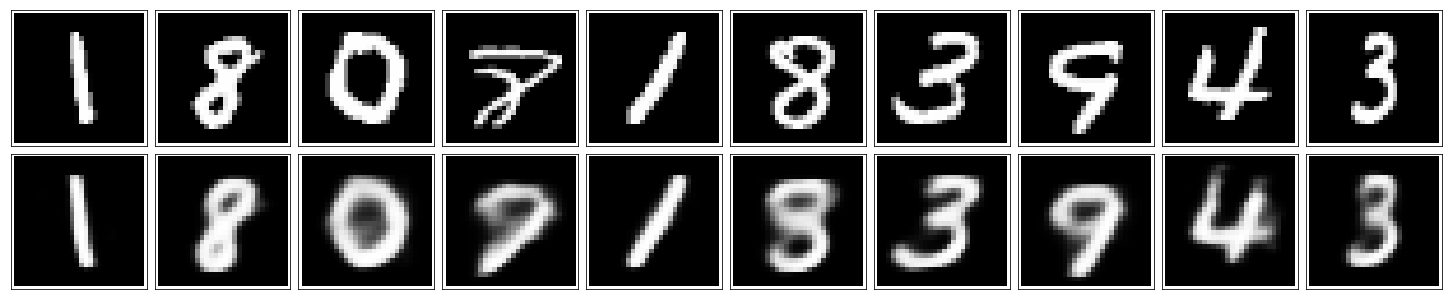

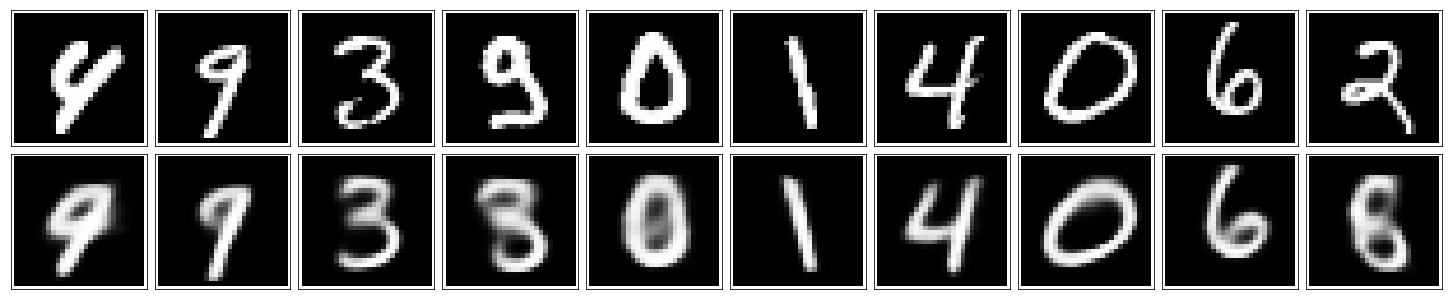

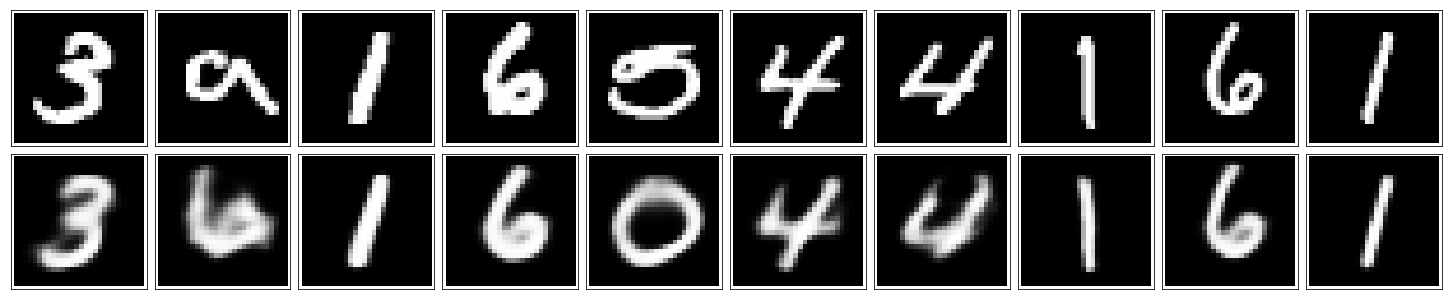

In [968]:
for i in range(5):
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
    in_imgs = mnist.train.images[10*i:10*(i+1)]
    reconstructed = decoded.eval(session=sess, feed_dict={x: in_imgs.reshape((10, 28, 28, 1))})

    for images, row in zip([in_imgs, reconstructed], axes):
        for img, ax in zip(images, row):
            ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


    fig.tight_layout(pad=0.1)

In [971]:
def make_scatter_mat(m, colors=[], name="v", title=""):
    columns = []
    for i in range( int( m.shape[1] ) ):
        columns.append(name + "_" + str(i+1))
    if "tensorflow" in type(m).__module__:
        arr = m.eval(session=sess, feed_dict={x : g_waves})
    else:
        arr = m
    if len(colors)==0:
        colors = 'b' * arr.shape[0]
    df = DataFrame(arr, columns=columns)
    scatter_matrix(df, alpha=np.min([1.0, 1000.0/(len(colors))]), c=colors, figsize=(16,16), diagonal="kde")

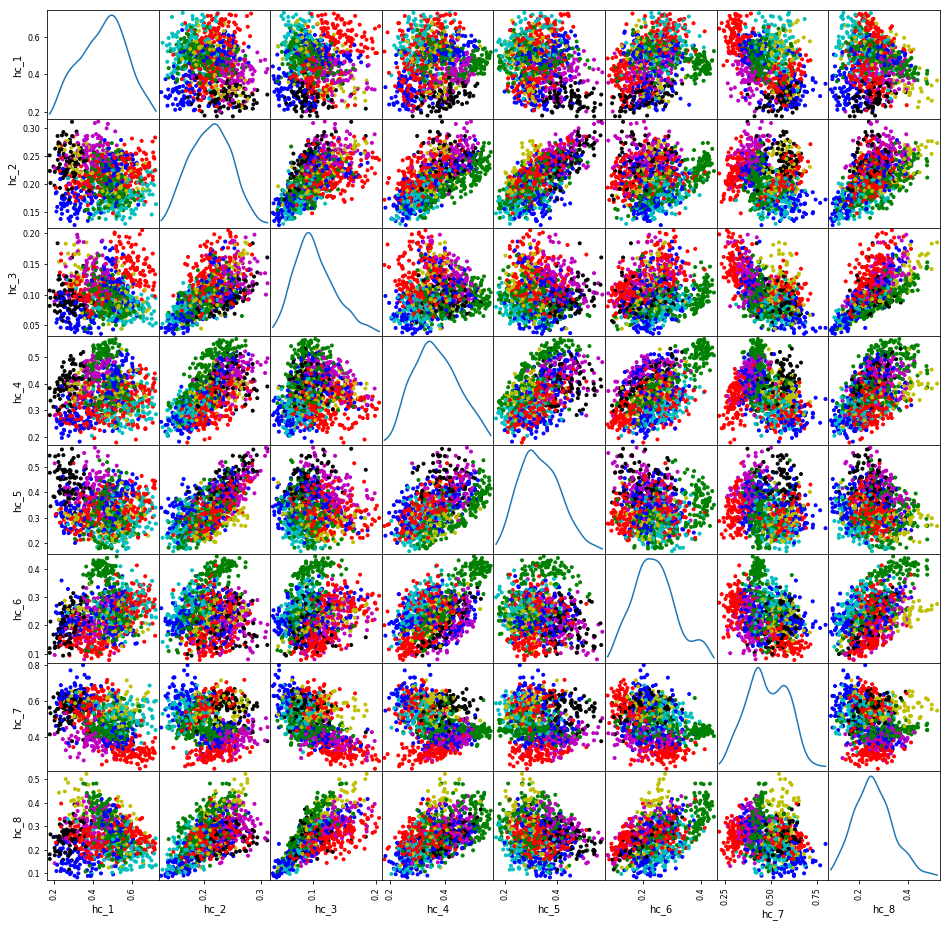

In [981]:
batch,hc_labels = mnist.train.next_batch(1024)
imgs = batch.reshape((-1, g_image_size, g_image_size, 1))
hc_nums = hc.eval(session=sess, feed_dict={x : imgs})

make_scatter_mat(hc_nums, [g_color_list[hc_labels[i]] for i in range(1024)], "hc", "Autoencoder")

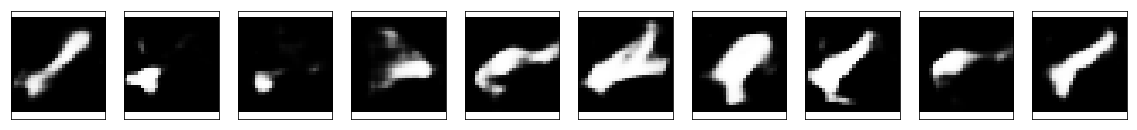

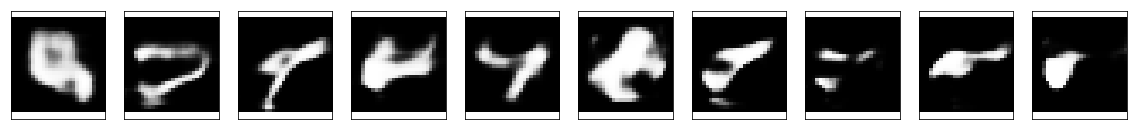

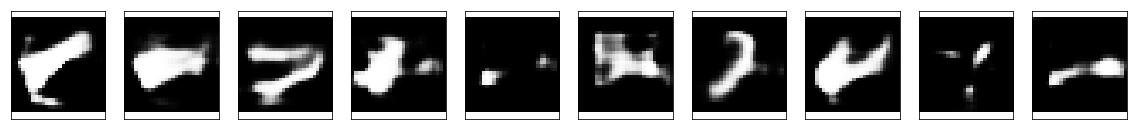

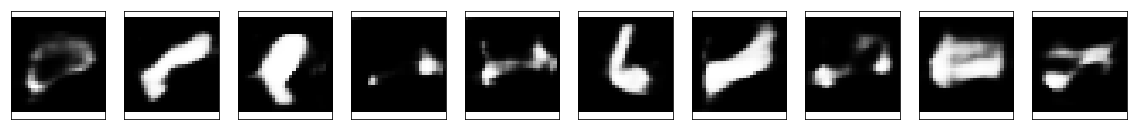

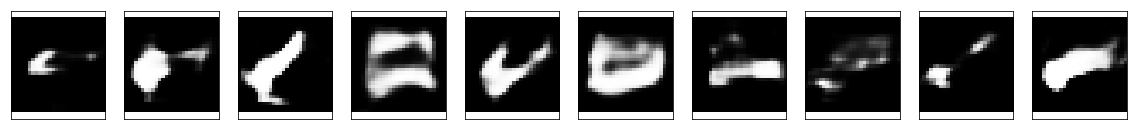

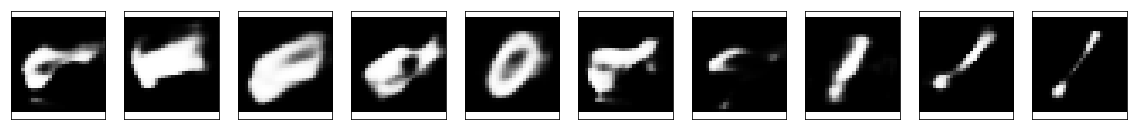

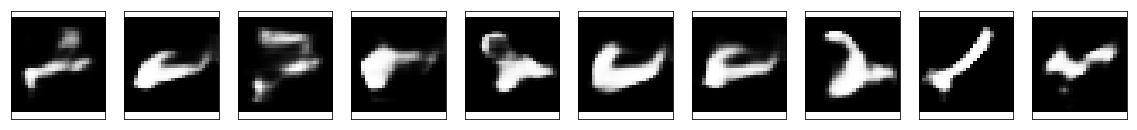

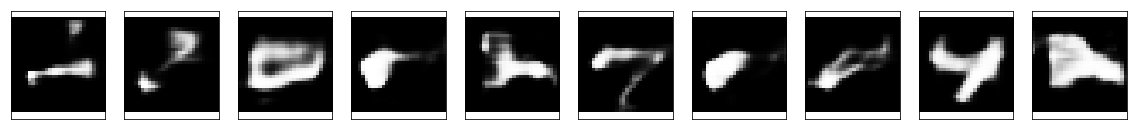

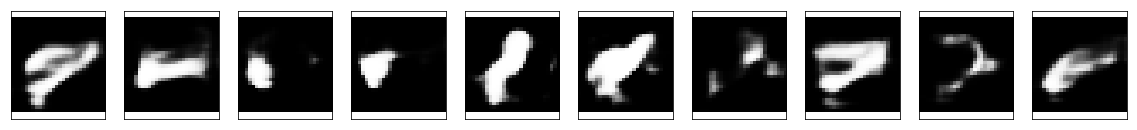

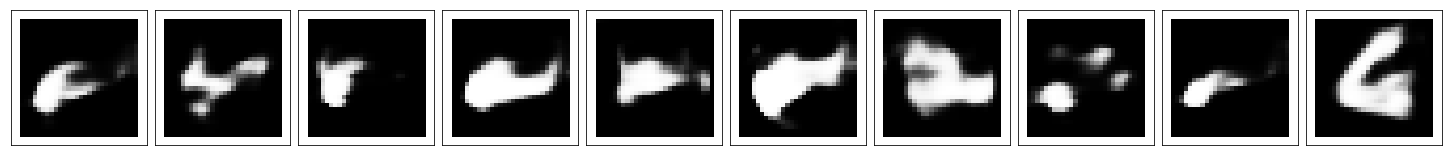

In [1009]:
rimgs = decoded.eval(session=sess, feed_dict={hc : np.random.rand(100,conf["numh"])/2})

for i in range(10):
    fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(20,2))
    in_imgs = rimgs[10*i:10*(i+1)]
#    reconstructed = decoded.eval(session=sess, feed_dict={x: in_imgs.reshape((10, 28, 28, 1))})

    for img, ax in zip(in_imgs, axes):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [985]:
rimgs.shape

(100, 28, 28, 1)

In [992]:
in_imgs.shape

(10, 28, 28, 1)

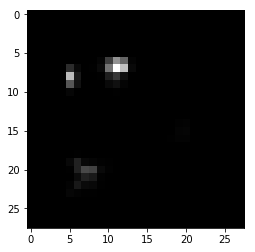

In [999]:
plt.imshow(rimgs[10,:,:,0], cmap='Greys_r')

In [1003]:
len(axes)

10